## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

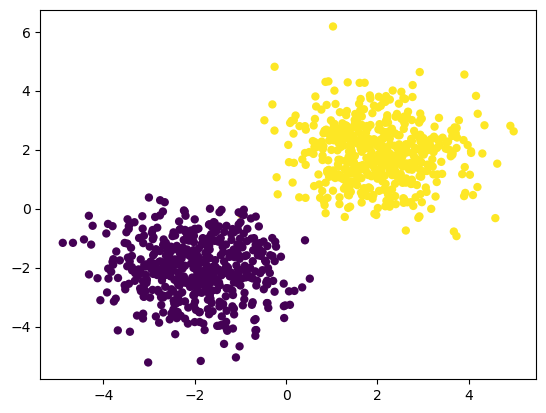

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

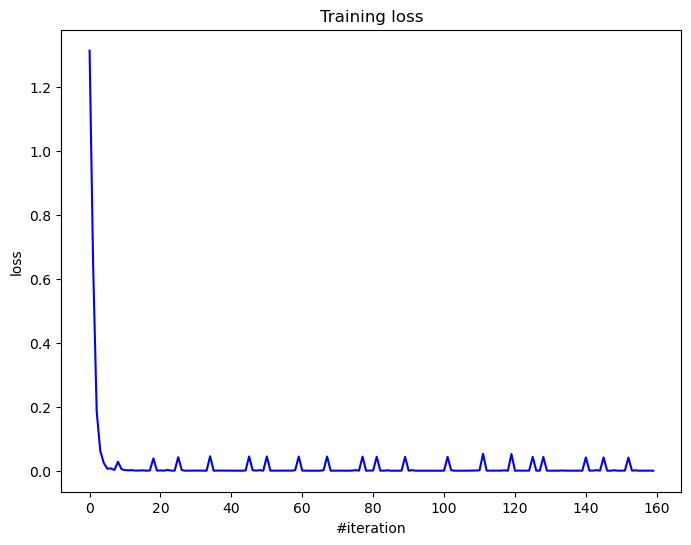

Current loss: 0.000027


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [8]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [9]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [10]:
# Your code goes here.
from IPython import display


def train_loop(
    models: list[list[object]],
    X_train: np.ndarray,
    Y_train: np.ndarray,
    batch_size: int,
    optimizer: callable,
    optimizer_config: dict,
    optimizer_state: list[list[dict]],
    loss_history: list[list[list[float]]],
    device: str = 'cpu') -> None:

    """
    Выполняет цикл обучения для вложенной структуры моделей.

    Эта функция перебирает коллекцию групп моделей и выполняет прямые
    и обратные проходы для обучения, обновляя веса с использованием указанного оптимизатора.

    Parameters
    ----------
    models : List[List[object]]
        A nested list of models where each inner list contains models to be trained together.
    X_train : np.ndarray
        Training input data of shape `(n_samples, n_features)`.
    Y_train : np.ndarray
        Training labels of shape `(n_samples,)` or `(n_samples, n_classes)`.
    batch_size : int
        Size of the batches for training.
    optimizer : callable
        Optimization function to update model parameters.
    optimizer_config : dict
        Configuration parameters for the optimizer.
    optimizer_state : List[List[dict]]
        State information for the optimizer, organized by model groups and individual models.
    loss_history : List[List[List[float]]]
        Nested list to store loss values for each model at each iteration.
    device : str, optional
        Target device for computation ('cpu' or 'cuda'). Default is 'cpu'.

    Returns
    -------
    None
        Updates models' parameters and populates `loss_history` in place.
    """

    for id, _model_group in enumerate(models):
        for batch_norm, model in enumerate(_model_group):

            model.train()

            for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
                pred = model.forward(x_batch)
                
                temp = np.zeros((len(y_batch), 10))
                for i in range(len(y_batch)):
                    temp[i][y_batch[i]] = 1
                y_batch = np.array(temp)
                
                loss = criterion.forward(pred, y_batch)
                
                dp = criterion.backward(pred, y_batch)
                model.backward(x_batch, dp)
    
                optimizer(
                    model.getParameters(),
                    model.getGradParameters(),
                    optimizer_config,
                    optimizer_state[id][batch_norm]
                )
                
                loss_history[id][batch_norm].append(loss)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [11]:
# Your code goes here.
def create_NN_model(activationFunc, insertBatch_norm = True, dropout = False) -> object:
    model = Sequential()
    model.add(Flatten())
    model.add(Linear(784, 392))
    if insertBatch_norm is True:
        model.add(BatchNormalization())
    if dropout is True:
        model.add(Dropout(0.3))
    model.add(activationFunc())
    model.add(Linear(392, 128))
    if insertBatch_norm is True:
        model.add(BatchNormalization())
    if dropout is True:
        model.add(Dropout(0.3))
    model.add(activationFunc())
    model.add(Linear(128, 10))
    model.add(SoftMax())
    return model

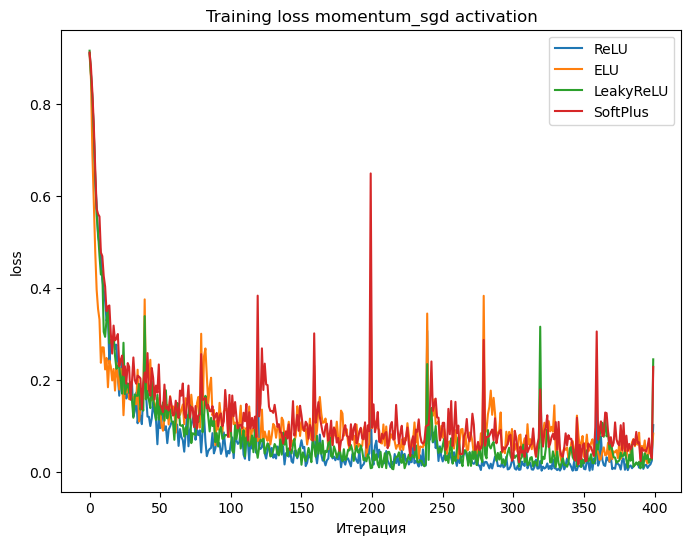

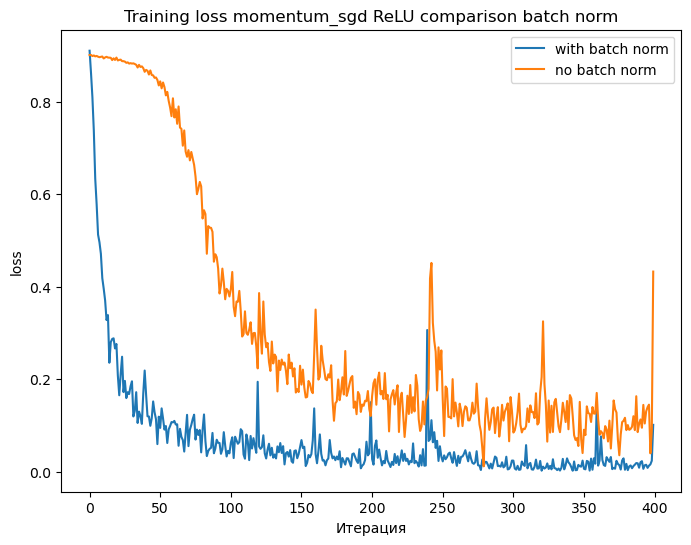

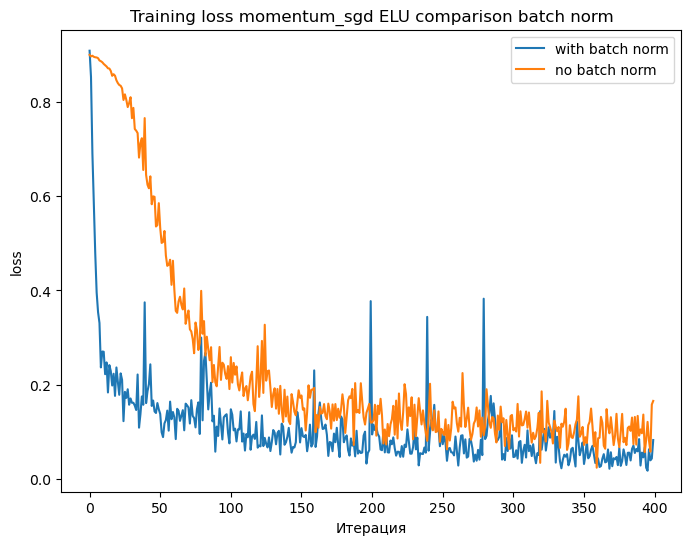

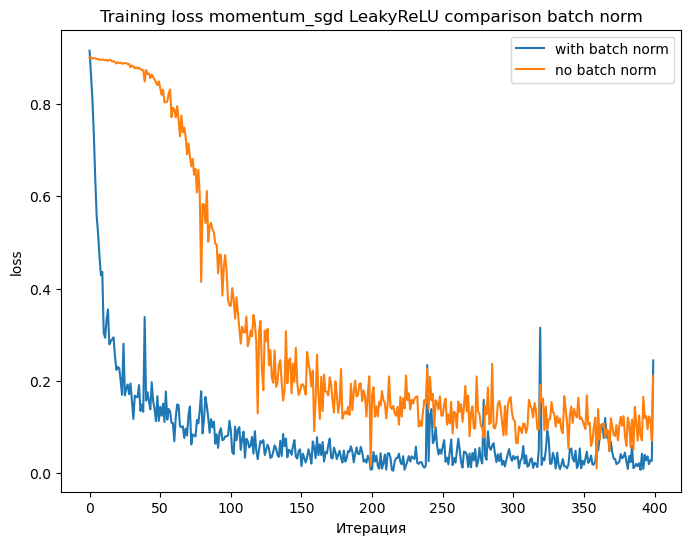

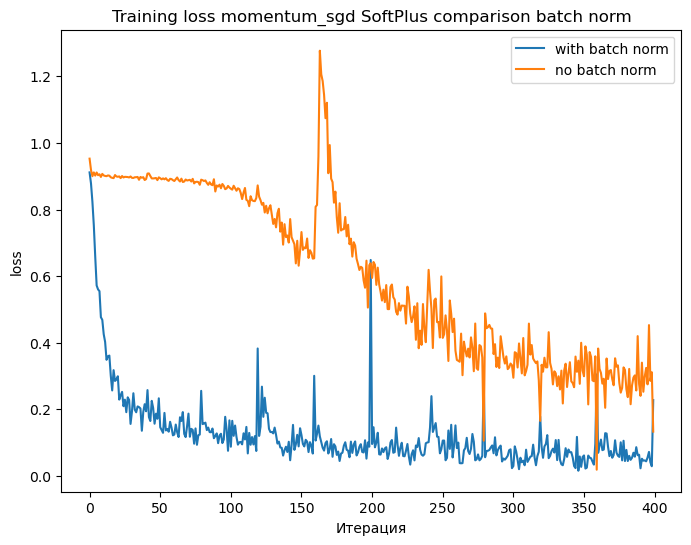

Current loss ReLU with batch norm: 0.10127199220611856
Current loss ReLU no batch norm: 0.43273149097981967
Current loss ELU with batch norm: 0.08280885942465276
Current loss ELU no batch norm: 0.16574305756597427
Current loss LeakyReLU with batch norm: 0.2443278629638121
Current loss LeakyReLU no batch norm: 0.2103012630037778
Current loss SoftPlus with batch norm: 0.22781583294823576
Current loss SoftPlus no batch norm: 0.13328812998307413


In [12]:
criterion = MSECriterion()
activation = [ReLU(), ELU(), LeakyReLU(), SoftPlus()]
NNs = [[create_NN_model(ReLU), create_NN_model(ReLU, False)], 
       [create_NN_model(ELU), create_NN_model(ELU, False)],
       [create_NN_model(LeakyReLU), create_NN_model(LeakyReLU, False)],
       [create_NN_model(SoftPlus), create_NN_model(SoftPlus, False)]]

n_epoch = 10
batch_size = 128
sgd_optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.7}
sgd_optimizer_state = [[{} for i in range(2)] for _ in range(len(NNs))]

loss_history = [[[] for i in range(2)] for _ in range(len(NNs))]
for i in range(n_epoch):
    train_loop(NNs, X_train[:5000], y_train[:5000], batch_size, sgd_momentum, sgd_optimizer_config, sgd_optimizer_state, loss_history)    
    display.clear_output(wait=False)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss momentum_sgd activation")
    plt.xlabel("Итерация")
    plt.ylabel("loss")
    
    for act, losses in zip(activation, loss_history):
        plt.plot(losses[0], label = act.__repr__())

    plt.legend()
    plt.show()

    for act, losses in zip(activation, loss_history):
        plt.figure(figsize=(8, 6))
        plt.title(f"Training loss momentum_sgd {act.__repr__()} comparison batch norm")
        plt.xlabel("Итерация")
        plt.ylabel("loss")
        plt.plot(losses[0], label = "with batch norm")
        plt.plot(losses[1], label = "no batch norm")
        plt.legend()
        plt.show()
    
    for act, losses in zip(activation, loss_history):
        print(f'Current loss {act.__repr__()} with batch norm: {losses[0][-1]}')
        print(f'Current loss {act.__repr__()} no batch norm: {losses[1][-1]}')

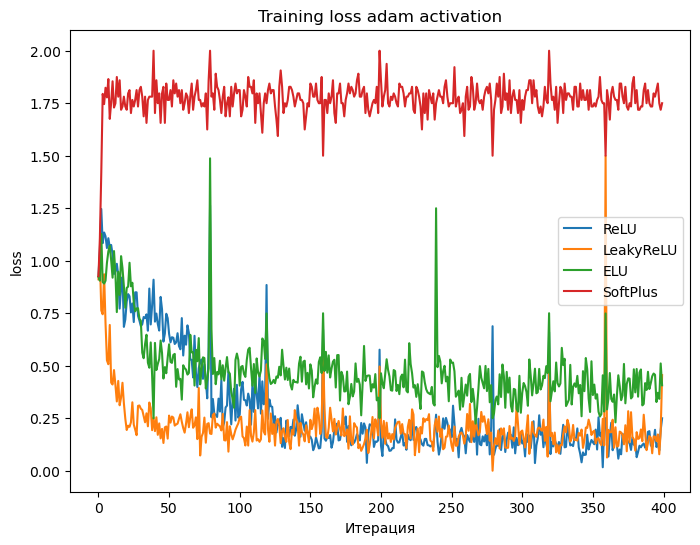

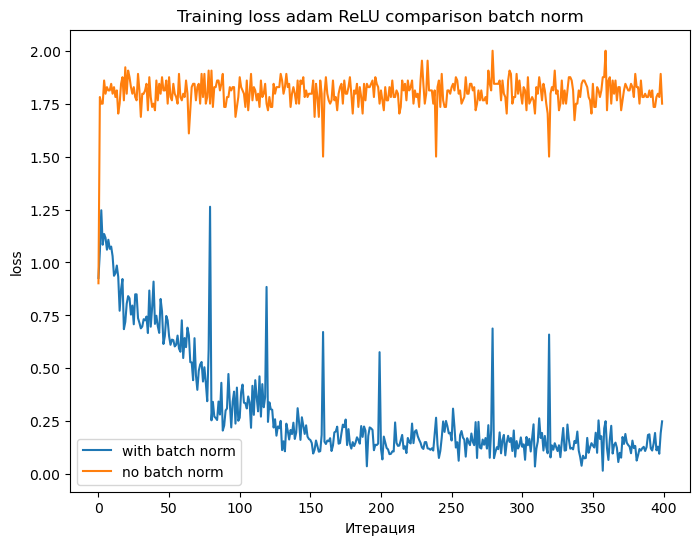

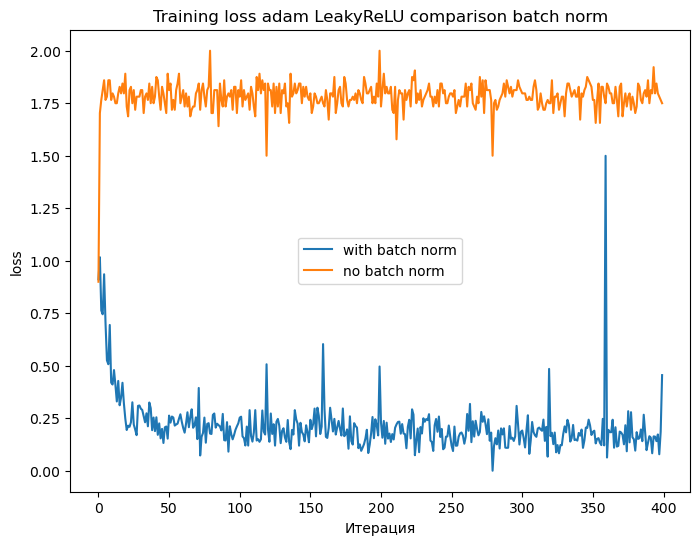

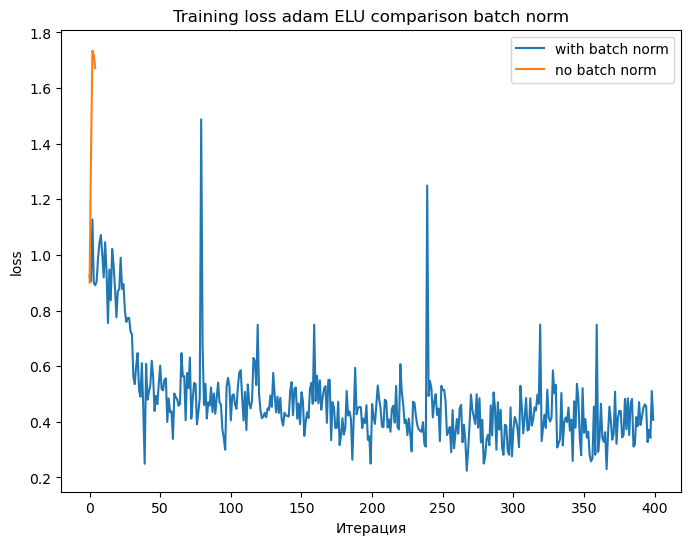

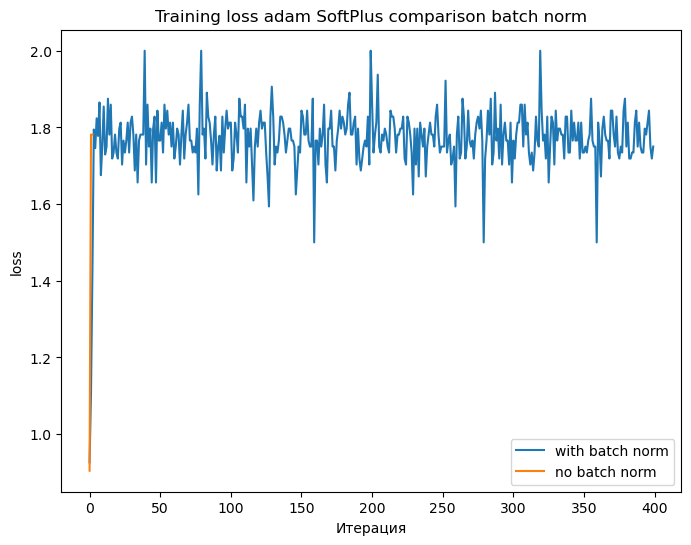

Current loss ReLU with batch norm: 0.24966874291456526
Current loss ReLU no batch norm: 1.75
Current loss LeakyReLU with batch norm: 0.45526134524028705
Current loss LeakyReLU no batch norm: 1.75
Current loss ELU with batch norm: 0.40695872173876063
Current loss ELU no batch norm: nan
Current loss SoftPlus with batch norm: 1.75
Current loss SoftPlus no batch norm: nan


In [13]:
criterion = MSECriterion()
activation = [ReLU(), LeakyReLU(), ELU(), SoftPlus()]
NNs = [[create_NN_model(ReLU), create_NN_model(ReLU, False)], 
       [create_NN_model(LeakyReLU), create_NN_model(LeakyReLU, False)],
       [create_NN_model(ELU), create_NN_model(ELU, False)],
       [create_NN_model(SoftPlus), create_NN_model(SoftPlus, False)]]

n_epoch = 10
batch_size = 128
adam_optimizer_config = {'learning_rate': 1e-1, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 1e-10}
adam_optimizer_state = [[{} for i in range(2)] for _ in range(len(NNs))]
loss_history = [[[] for i in range(2)] for _ in range(len(NNs))]

for i in range(n_epoch):
    train_loop(NNs, X_train[:5000], y_train[:5000], batch_size, adam_optimizer, adam_optimizer_config, adam_optimizer_state, loss_history)    

    display.clear_output(wait=False)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss adam activation")
    plt.xlabel("Итерация")
    plt.ylabel("loss")
    
    for act, losses in zip(activation, loss_history):
        plt.plot(losses[0], label = act.__repr__())

    plt.legend()
    plt.show()

    for act, losses in zip(activation, loss_history):
        plt.figure(figsize=(8, 6))
        plt.title(f"Training loss adam {act.__repr__()} comparison batch norm")
        plt.xlabel("Итерация")
        plt.ylabel("loss")
        plt.plot(losses[0], label = "with batch norm")
        plt.plot(losses[1], label = "no batch norm")
        plt.legend()
        plt.show()
    
    for act, losses in zip(activation, loss_history):
        print(f'Current loss {act.__repr__()} with batch norm: {losses[0][-1]}')
        print(f'Current loss {act.__repr__()} no batch norm: {losses[1][-1]}')

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

About BatchNormalization:

It is very good for getting better results on this dataset loss decrements faster and more stability for each activation function with adam optimizer it is very bad and it save from overflow

About activation function
ReLU and LeakyReLU show better results for it and ELU the worst. Also SoftMax the worst without batch normalization. ReLU and LeakyReLU almost the same and ELU and softmax also similar with batch Normalization
ELU and SoftMax can be overflowed in calculations and it very bad and because of it I don't recommed use it

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

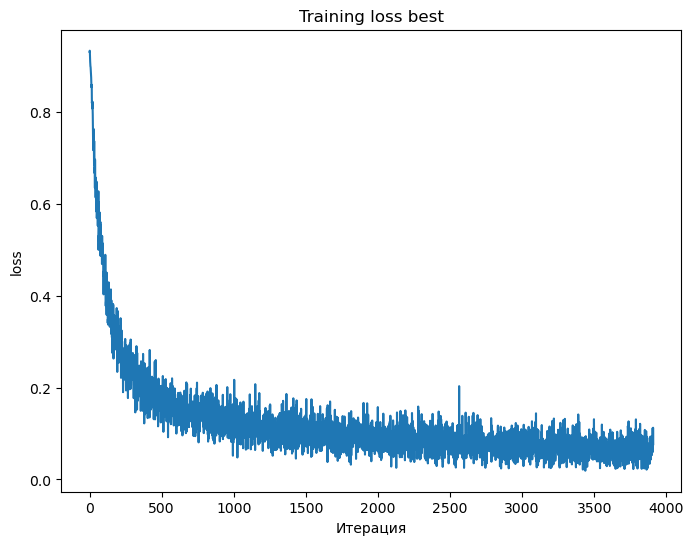

In [14]:
# Your code goes here.

best = [[create_NN_model(LeakyReLU, True, True)]]
sgd_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.7}
sgd_optimizer_state = [[{}]]
loss_history = [[[]]]

for i in range(n_epoch):
    train_loop(best, X_train, y_train, batch_size, sgd_momentum, sgd_optimizer_config, sgd_optimizer_state, loss_history)

    display.clear_output(wait=False)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss best")
    plt.xlabel("Итерация")
    plt.ylabel("loss")
    plt.plot(loss_history[0][0])
    plt.show()

best = best[0][0]

Print here your accuracy on test set. It should be around 90%.

In [15]:
# Your answer goes here.
best.evaluate()
pred = best.forward(X_test).argmax(axis=1, keepdims=True)
print("Accuracy of NN: ", np.sum(pred == y_test.reshape(len(X_test), 1))/len(X_test))

Accuracy of NN:  0.7831


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [16]:
import torch
import torch.nn as nn
from IPython.display import clear_output

def train_torch(dataloader, model, loss_fn, optimizer, device):
    data, labels = dataloader
    size = len(labels)
    model.train()
    for batch, (X, y) in enumerate(get_batches(dataloader, batch_size)):
        X = torch.tensor(X).to(device)
        y = torch.tensor(y).to(device)
        pred = model(X)
        pred
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_torch(dataloader, model, loss_fn, device):
    model.eval()
    data, labels = dataloader
    size = len(labels)
    num_batches = 0
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in get_batches(dataloader, batch_size):
            X = torch.tensor(X).to(device)
            y = torch.tensor(y).to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            num_batches += 1

    test_loss /= num_batches
    correct /= size
    clear_output(wait=True)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
class TorchNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        print(input_shape)
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 392),
            nn.BatchNorm1d(392),
            nn.Dropout(0.3),
            nn.LeakyReLU(),
            nn.Linear(392, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.LeakyReLU(),
            nn.Linear(128, 10),
            nn.BatchNorm1d(10),
            nn.Softmax(dim=1)
        )

    def forward(self, inp):       
        out = self.model(inp)
        return out

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

model = TorchNeuralNetwork().to(device)
print(model)

cuda:0
784
TorchNeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=392, bias=True)
    (2): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=392, out_features=128, bias=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=128, out_features=10, bias=True)
    (10): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Softmax(dim=1)
  )
)


In [18]:
opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

epochs = 10
for i in range(epochs):
    print(f"\nEpoch {i+1}:\n")
    train_torch((X_train, y_train), model, loss_func, opt, device)
    test_torch((X_test, y_test), model, loss_func, device)
print("Done!")

Test Error: 
 Accuracy: 96.4%, Avg loss: 1.517452 

Done!
